In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
from numpy import array, bincount, log2, vstack, ones
from numpy.linalg import lstsq
pylab.rcParams['figure.figsize'] = (20.0, 20.0)
log = log2

## Initial conditions

In [2]:
MU = 3.9
N = int(10E4)
INITIAL = 0.5
MIN_SIZE = 2
MAX_SIZE = 26
BITS_RANGE = array(list(range(MIN_SIZE, MAX_SIZE + 1)))

In [3]:
def generate(x, mu, n):
    current = x
    for _ in range(n):
        yield current
        current = mu * current * (1 - current)

In [4]:
def bin_to_dec(sequence, bits):
    aligned_sequence = sequence.flatten()[:sequence.size - sequence.size % bits]
    binary_matrix = aligned_sequence.reshape((sequence.size // bits, bits))
    result_sequence = array([binary_matrix[:,i] * (2**i) for i in range(binary_matrix.shape[1])])
    return result_sequence.sum(axis=0)

In [5]:
def R(probabilities, beta):
    return -log((probabilities[probabilities>0]**beta).sum()) / (beta - 1)

In [6]:
def H(probabilities):
    indices = probabilities>0
    return -(log(probabilities[indices]) * probabilities[indices]).sum()

In [7]:
def show_entropies(entropies, errors=None, count=None, labels=None):
    for entropy, label in zip(entropies, labels):
        if count is None:
            plt.plot(BITS_RANGE, entropy, '-o', label=label)
        else:
            plt.plot(BITS_RANGE[:count], entropy, '-o', label=label)
    if errors is not None:
        plt.errorbar(**errors)
    plt.legend()
    plt.show()

## Generate a sequence

Generate long sequence of real numbers

For further analysis it's handy to convert it to binary array

Then we can get different sequences of integers by splitting binary array into blocks

In [8]:
source_sequence = array(list(generate(INITIAL, MU, N)))
bin_sequence = (source_sequence > 0.5).astype('i')
sequences = array([bin_to_dec(bin_sequence, bits_count).astype('i') for bits_count in BITS_RANGE])
probabilities = array([bincount(sequence)/sequence.size for sequence in sequences])
probabilities[1]

array([ 0.        ,  0.10110101,  0.21093211,  0.1201212 ,  0.100171  ,
        0.22755228,  0.1195512 ,  0.12057121])

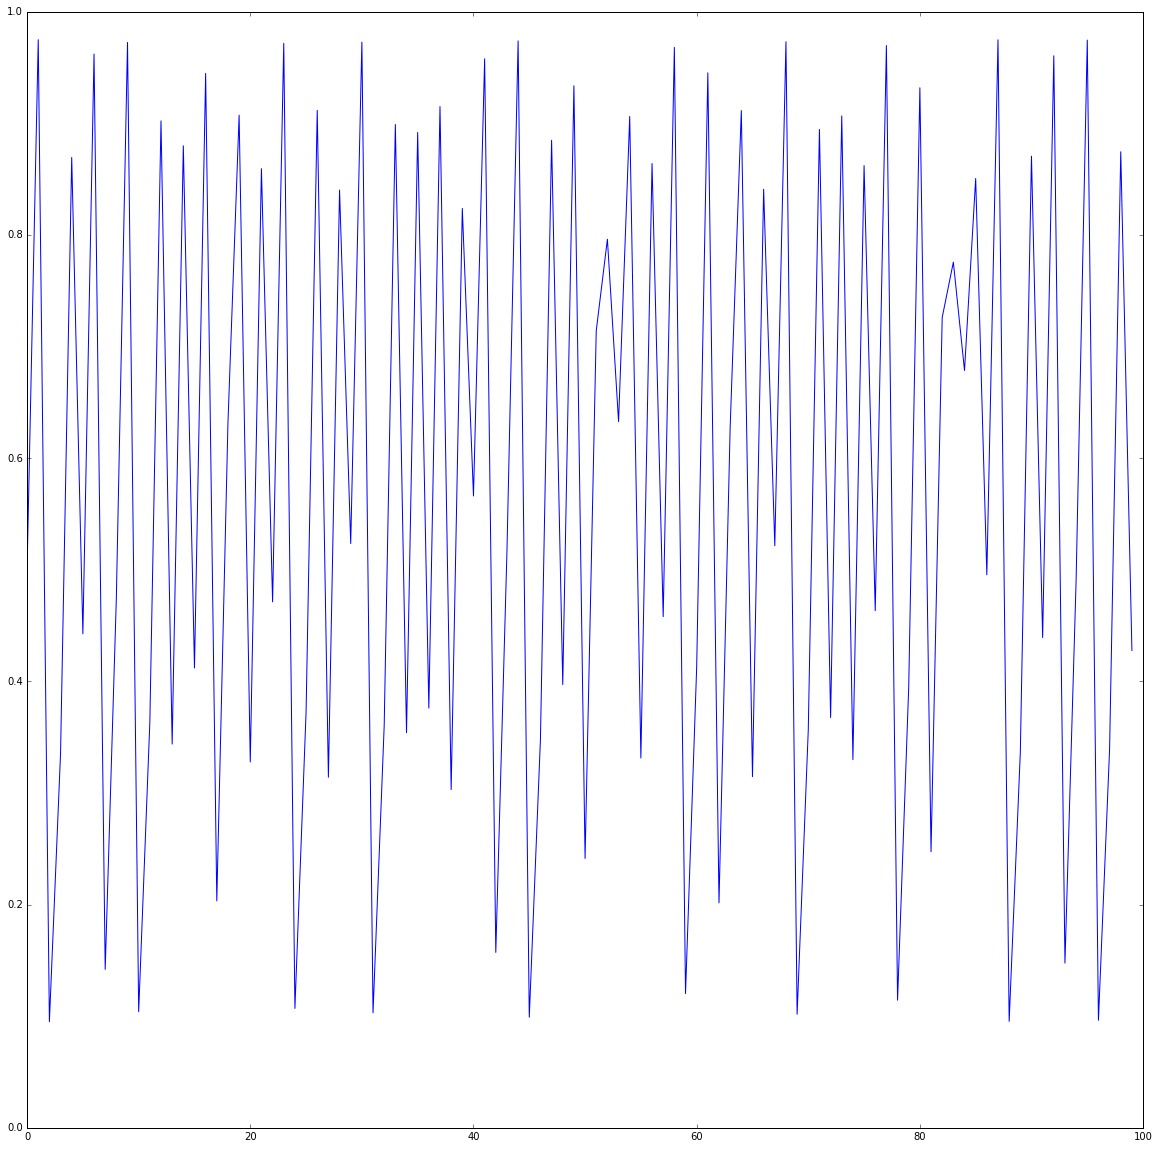

In [9]:
plt.plot(source_sequence[:100])
plt.show()

## Entropies

We need to calculate different entropies for each sequence

In [10]:
shannon_entropies = [H(p) for p in probabilities]
renyi_entropies2 = [R(p, 2) for p in probabilities]
renyi_entropies3 = [R(p, 3) for p in probabilities]

Now we have mappings from binary block size to entropies of sequences

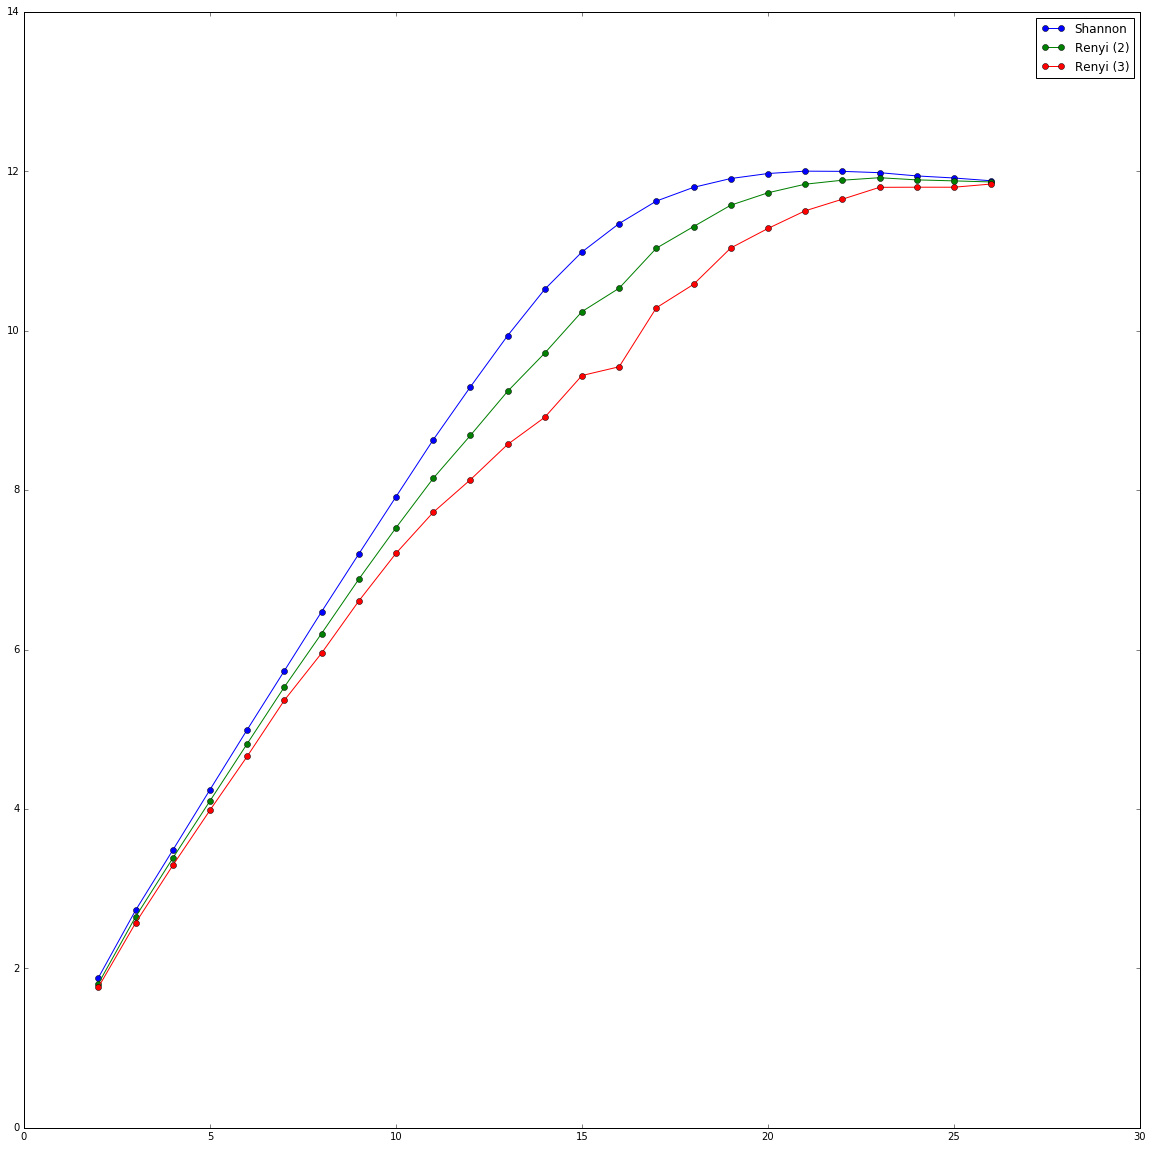

In [11]:
show_entropies([shannon_entropies, renyi_entropies2, renyi_entropies3], labels=['Shannon', 'Renyi (2)', 'Renyi (3)'])

Now we will calculate average entropy for each block size

In [12]:
means = array([shannon_entropies, renyi_entropies2, renyi_entropies3]).mean(axis=0)

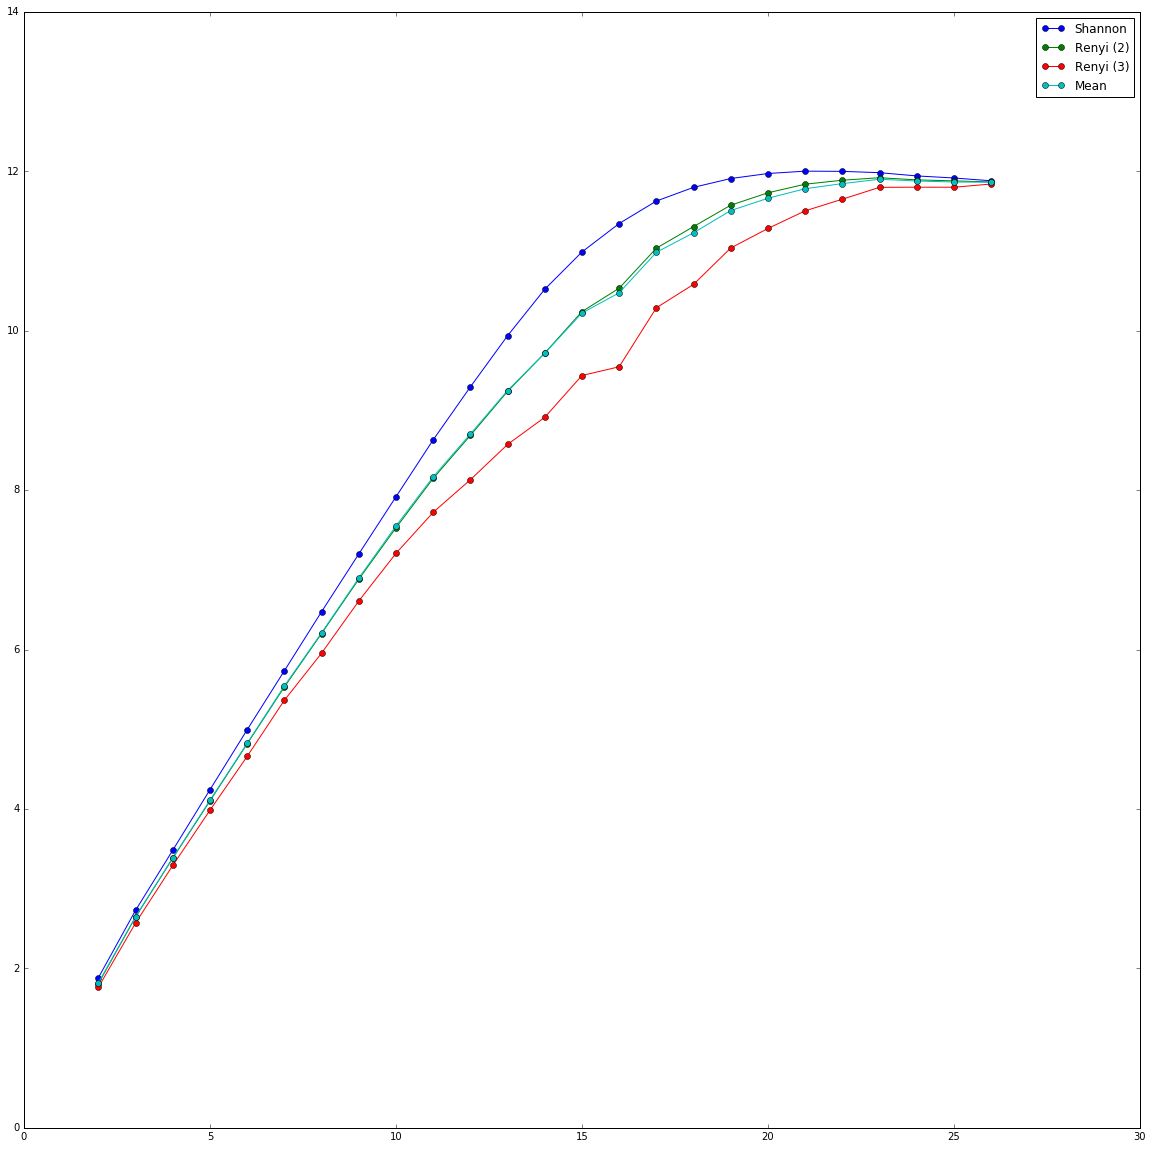

In [13]:
show_entropies([shannon_entropies, renyi_entropies2, renyi_entropies3, means], labels=['Shannon', 'Renyi (2)', 'Renyi (3)', 'Mean'])

Get same entropies for chaotic sequence

Sequences of uniformly distributed numbers with same binary sizes as existent sequences have the biggest possible entropies

In [14]:
shannon_entropies_chaos = [n*log(2) for n in BITS_RANGE]
renyi_entropies2_chaos = [-(n*log(2)-2*n*log(2)) for n in BITS_RANGE]
renyi_entropies3_chaos = [-(n*log(2)-3*n*log(2))/2 for n in BITS_RANGE]

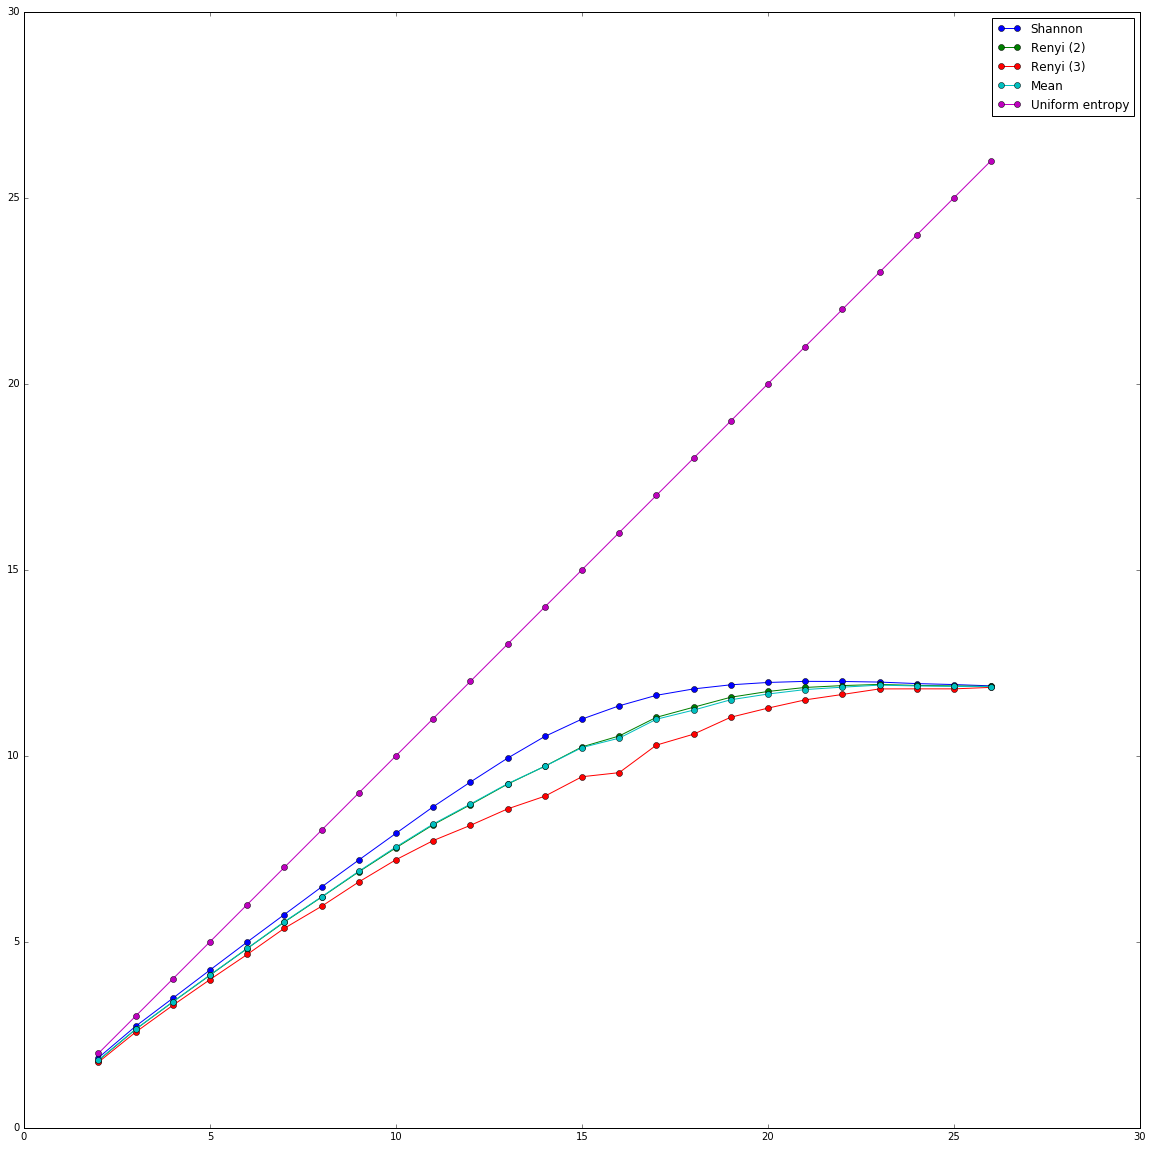

In [15]:
show_entropies([shannon_entropies, renyi_entropies2, renyi_entropies3, means, shannon_entropies_chaos], labels=['Shannon', 'Renyi (2)', 'Renyi (3)', 'Mean', 'Uniform entropy'])

To get only needed numbers we need to calculate standard deviations

It will show us how good the average value estimates entropy of the source

In [16]:
standard_deviation = array([shannon_entropies, renyi_entropies2, renyi_entropies3]).std(axis=0)

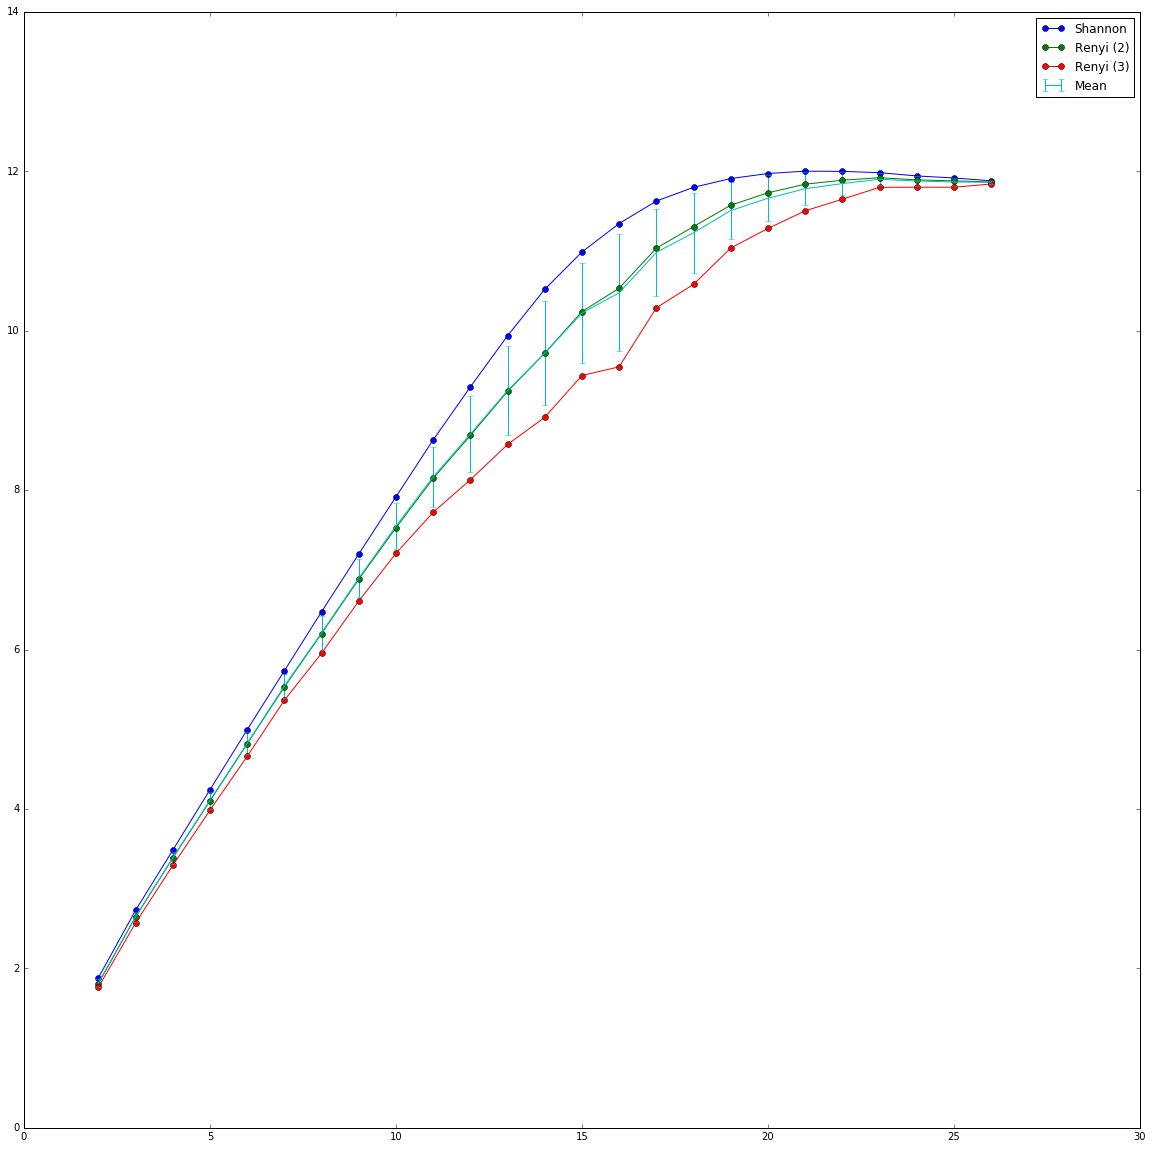

In [17]:
show_entropies([shannon_entropies, renyi_entropies2, renyi_entropies3], labels=['Shannon', 'Renyi (2)', 'Renyi (3)'], errors={'x': BITS_RANGE, 'y': means, 'yerr': standard_deviation, 'label': 'Mean'})

## Analysis

We can see from the chart that standard deviation grows to some moment and then falls down

Experiments with other source sequences have shown that the point with maximal standard deviation moves to right with sequence size growth

This can mean that before that moment we can gather data which is good for entropy estimate and after that we have not enough numbers for estimate

For example, when block size is equal to sequence length, entropy will be zero but source generates different pseudorandom numbers

## Estimate

Entropy of the source should be calculated as
```
H = lim(n to infinity) Hn/n
```
where `n` is a block size and `Hn` is an entropy of the sequence with size of block equal to `n`

Here are following conserns:
- we cannot get `n` big enough without sequence size increase;
- it's impossible to get very big sequence;
- estimate based on single block size will have undefined error

We can use least squares method to estimate the mean entropies (will be denoted as `Hn'`) using linear model
```
Hn' = k * n + c
```
Here `k` will be an estimate of `H` because following equality will take a place when `n` is big enough
```
Hn'/n = k + c/n -> k = H
```

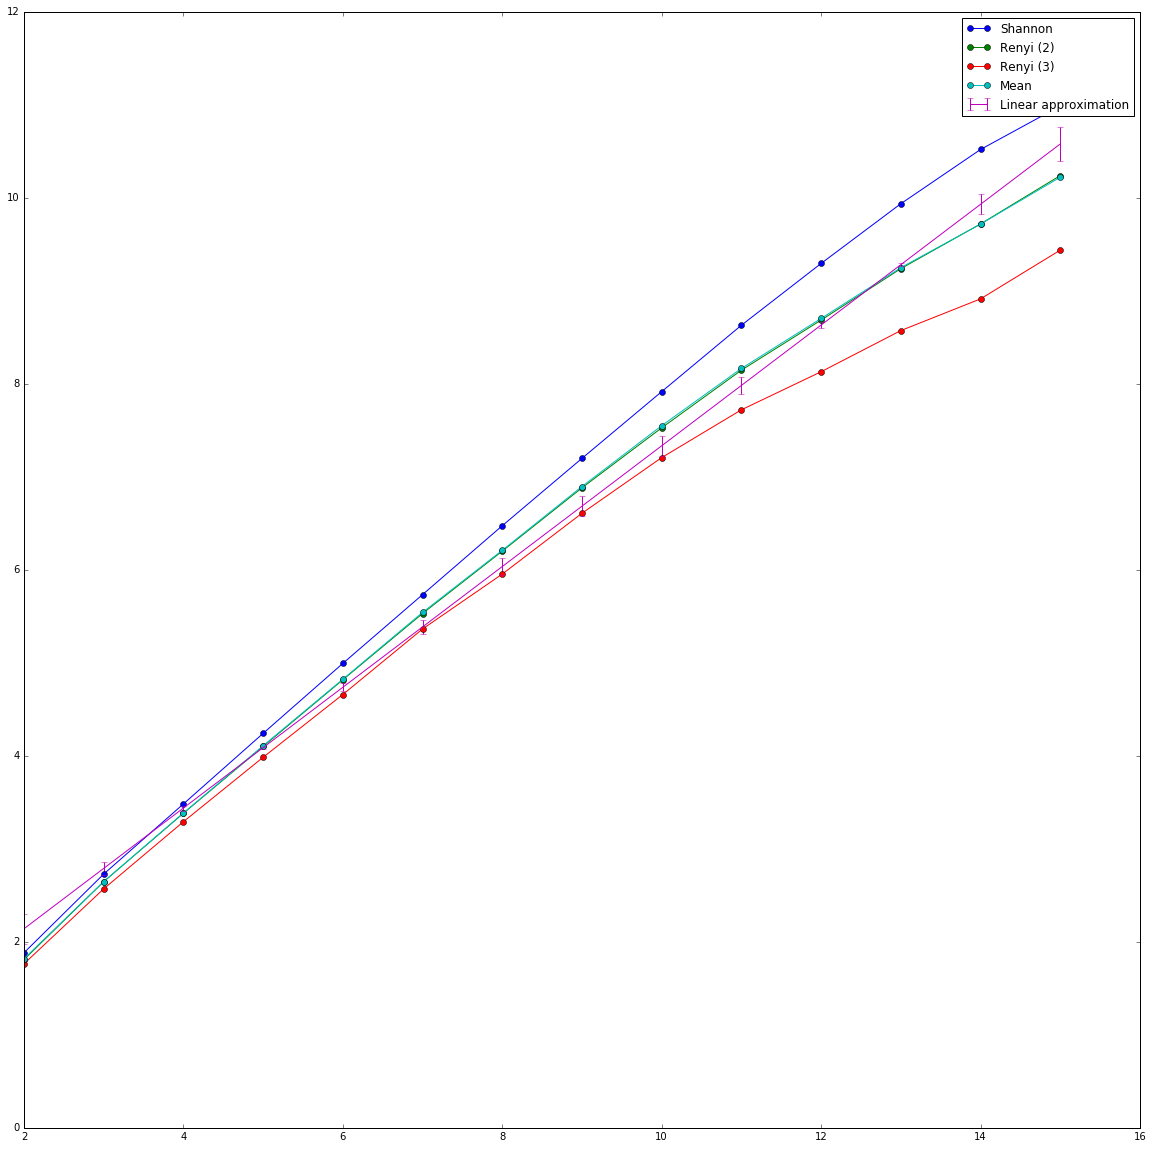

In [18]:
count = standard_deviation.argmax()
a, b = lstsq(vstack([BITS_RANGE[:count], ones(count)]).T, means[:count])[0]
approximation_error = array([means[:count], a*BITS_RANGE[:count]+b]).std(axis=0)
show_entropies([shannon_entropies[:count], renyi_entropies2[:count], renyi_entropies3[:count], means[:count]], labels=['Shannon', 'Renyi (2)', 'Renyi (3)', 'Mean'], errors={'x': BITS_RANGE[:count], 'y': a*BITS_RANGE[:count]+b, 'yerr': approximation_error, 'label': 'Linear approximation'}, count=count)

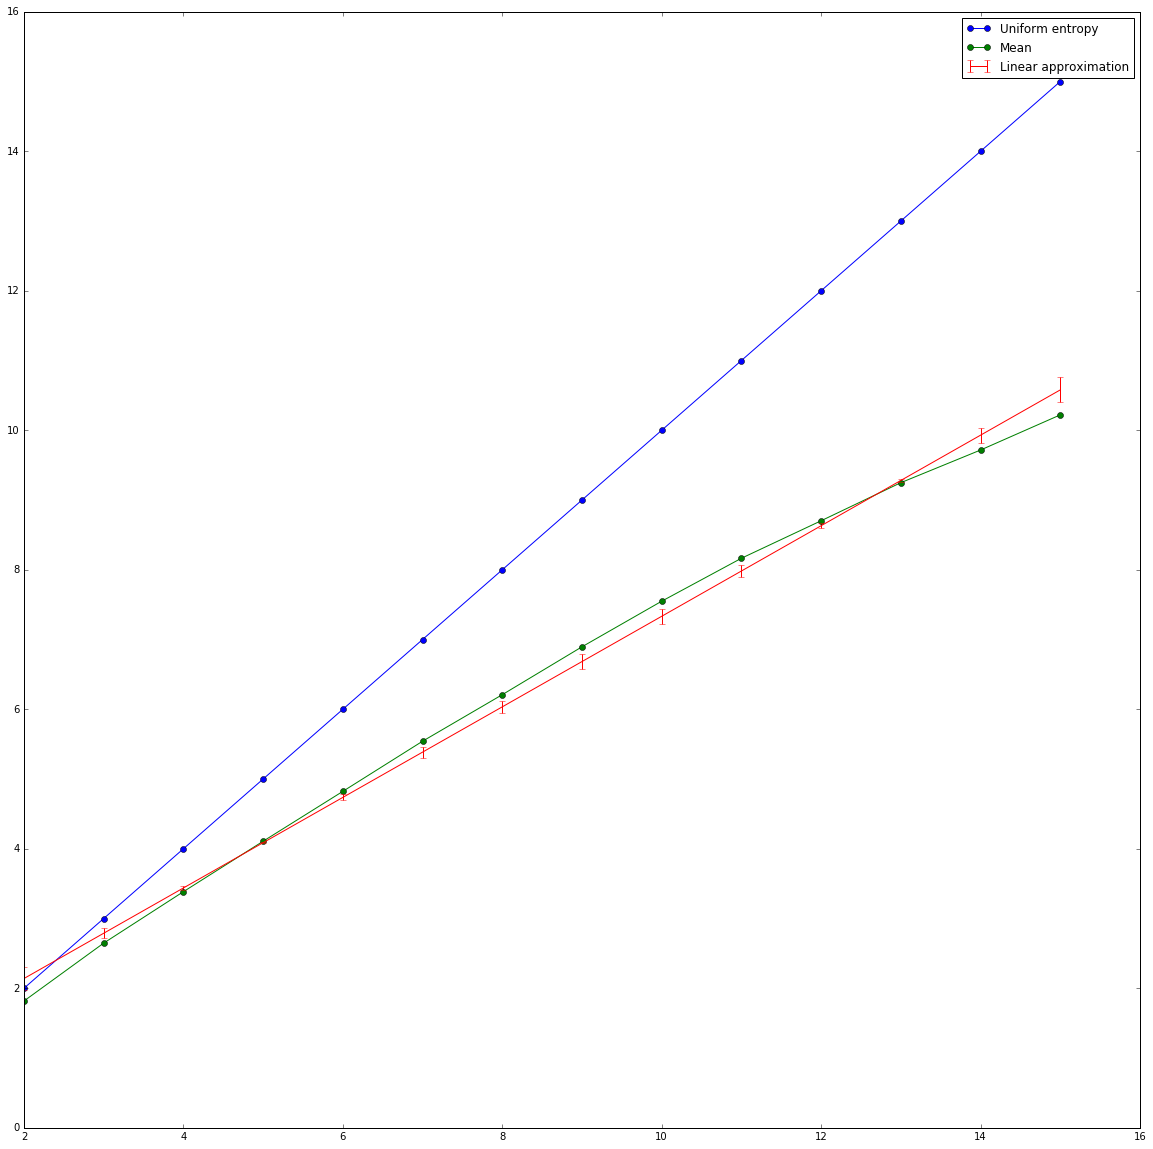

In [19]:
show_entropies([shannon_entropies_chaos[:count], means[:count]], labels=['Uniform entropy', 'Mean'], errors={'x': BITS_RANGE[:count], 'y': a*BITS_RANGE[:count]+b, 'yerr': approximation_error, 'label': 'Linear approximation'}, count=count)

## Results

Here are estimate of the source entropy and value of chaotic source

In [20]:
print('Source entropy estimate is', a)
print('Chaotic entropy is', log(2))

Source entropy estimate is 0.649154532535
Chaotic entropy is 1.0
